## Personalised Movie Recommendation System

In [52]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
import ast
import random

from surprise import Dataset, Reader, NMF, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split, cross_validate

import pickle
import warnings
warnings.filterwarnings("ignore")

In [54]:
movies = pd.read_csv('data/movies_metadata.csv')
ratings = pd.read_csv('data/ratings_small.csv')

In [55]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [56]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [57]:
movies.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [58]:
# Drop columns that are not going to be used
movies.drop(['homepage','original_title','tagline','spoken_languages','overview','poster_path','video', 'belongs_to_collection'],axis=1,inplace=True)
movies.dropna(inplace=True)
movies.head()

,adult,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,status,title,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,Released,Grumpier Old Men,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0


In [59]:
# Some columns have JSON format, convert them to lists
def json_to_list(row,want='name'):
    new_list = ast.literal_eval(row)    
    if new_list == [] or isinstance(new_list,float):
        return (np.nan)
    else:
        inner = []
        for j in new_list:
            inner.append(j[want])
        return (inner)
    
movies[['production_companies']] = movies[['production_companies']].applymap(json_to_list)
movies[['production_countries']] = movies[['production_countries']].applymap(lambda row: json_to_list(row ,'iso_3166_1'))
movies[['genres']] = movies[['genres']].applymap(json_to_list)

In [61]:
# Some columns contain information in arrays
def get_all_items(df, col):
    all_items = {}
    for items in df[col]:
        # Check if 'items' is NaN or an empty list
        if items is None or (isinstance(items, float) and pd.isna(items)):
            continue
        
        # Now process each genre dictionary within the list
        for genre in items:
            if genre in all_items:
                all_items[genre] += 1
            else:
                all_items[genre] = 1

    return all_items

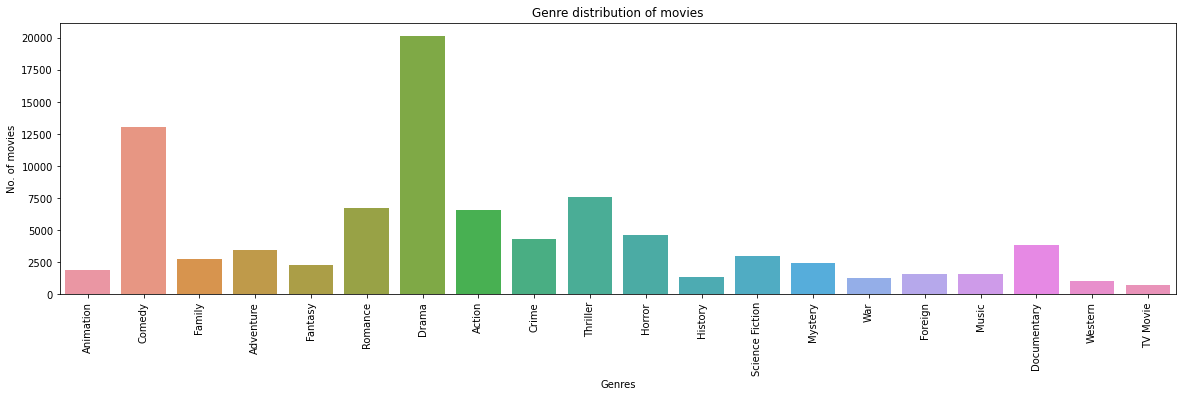

In [62]:
all_genres = get_all_items(movies, 'genres')

fig = plt.figure(figsize=(20, 5))
all_genre_keys = list(all_genres.keys())
all_genre_values = [int(i) for i in all_genres.values()]
sns.barplot(x=all_genre_keys, y=all_genre_values)

plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('No. of movies')
plt.title('Genre distribution of movies')
plt.show()

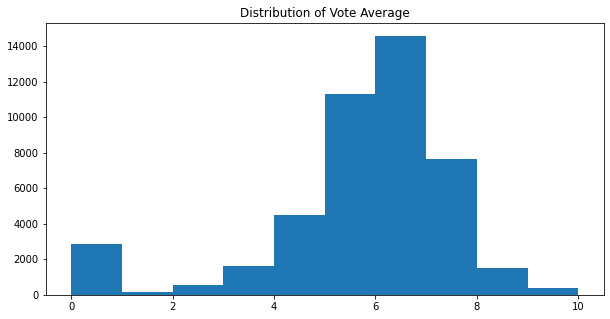

In [63]:
# Distribution of vote average
plt.figure(figsize=(10,5))
plt.hist(movies['vote_average'])
plt.title('Distribution of Vote Average')
plt.show()

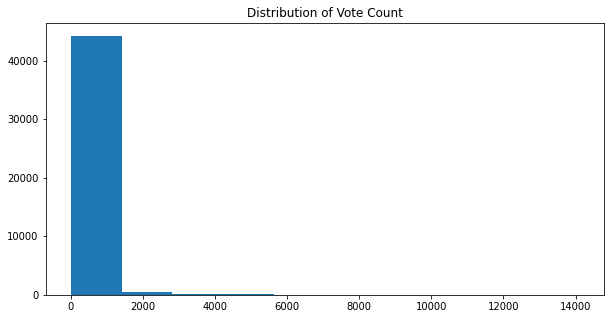

In [64]:
# Distribution of vote count
plt.figure(figsize=(10,5))
plt.hist(movies['vote_count'])
plt.title('Distribution of Vote Count')
plt.show()

In [65]:
# Distribution of original language
fig = px.histogram(movies, x='original_language')
fig.show()

In [66]:
# Select relevant columns
movies = movies[['id', 'title', 'genres', 'vote_average', 'vote_count']]

# Convert vote_average and vote_count to numeric
movies['vote_average'] = pd.to_numeric(movies['vote_average'], errors='coerce')
movies['vote_count'] = pd.to_numeric(movies['vote_count'], errors='coerce')

# Drop rows with missing values
movies.dropna(subset=['id', 'title', 'vote_average', 'vote_count'], inplace=True)

# Ensure movieId is integer
movies['id'] = movies['id'].astype(int)

movies.head()

,id,title,genres,vote_average,vote_count
0,862,Toy Story,"[Animation, Comedy, Family]",7.7,5415.0
1,8844,Jumanji,"[Adventure, Fantasy, Family]",6.9,2413.0
2,15602,Grumpier Old Men,"[Romance, Comedy]",6.5,92.0
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]",6.1,34.0
4,11862,Father of the Bride Part II,[Comedy],5.7,173.0


In [67]:
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [68]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The user-movie pivot table will look mostly empty since the users do not have to rate all the movies. Now let's check the distribution of ratings and eliminate the movies with less number of ratings and the users who did not rate a lot of movies which has less significance.

In [69]:
movies.rename(columns={'id': 'movieId'}, inplace=True)
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres,vote_average,vote_count
0,1,1371,2.5,1260759135,Rocky III,[Drama],6.6,894.0
1,4,1371,4.0,949810302,Rocky III,[Drama],6.6,894.0
2,7,1371,3.0,851869160,Rocky III,[Drama],6.6,894.0
3,19,1371,4.0,855193404,Rocky III,[Drama],6.6,894.0
4,21,1371,3.0,853852263,Rocky III,[Drama],6.6,894.0


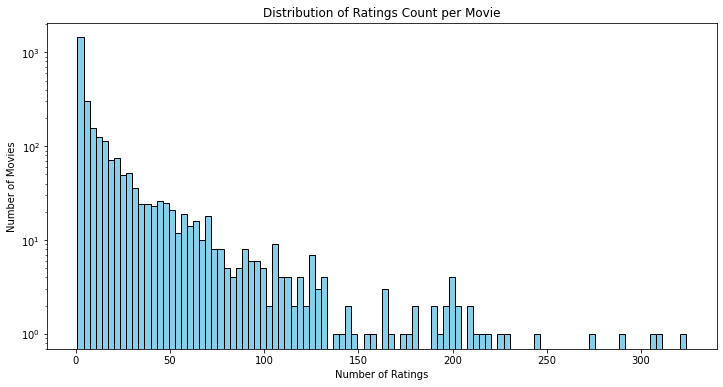

In [70]:
# Calculate the number of ratings per movie
ratings_count = merged_df.groupby('title').size().sort_values(ascending=False)

# Plot the distribution of ratings count
plt.figure(figsize=(12, 6))
plt.hist(ratings_count, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings Count per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.yscale('log')  # Use log scale for better visualization
plt.show()

As it can be seen here, most of the movies are rated close to 0 times. Let's try again after removing these movies.

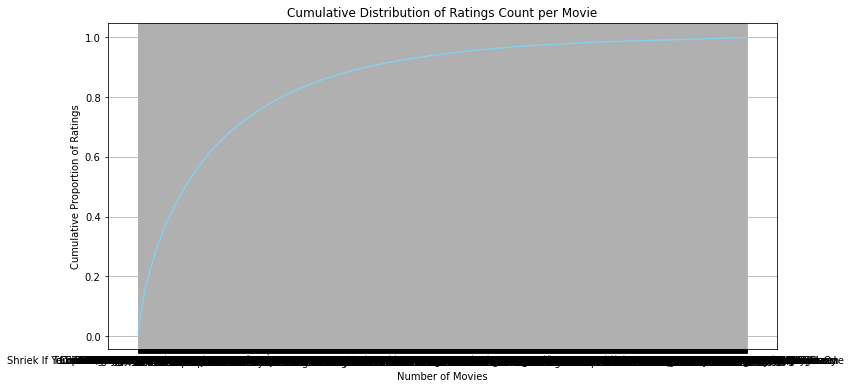

In [71]:
# Calculate the cumulative distribution of ratings
cumulative_ratings = ratings_count.cumsum() / ratings_count.sum()

# Plot the cumulative distribution
plt.figure(figsize=(12, 6))
plt.plot(cumulative_ratings, color='skyblue')
plt.title('Cumulative Distribution of Ratings Count per Movie')
plt.xlabel('Number of Movies')
plt.ylabel('Cumulative Proportion of Ratings')
plt.grid(True)
plt.show()

In [72]:
# Calculate the number of ratings per movie
ratings_count = merged_df.groupby('title').size().sort_values(ascending=False)

# Calculate the cumulative distribution of ratings
cumulative_ratings = ratings_count.cumsum() / ratings_count.sum()

# Determine the 90% coverage threshold
threshold_90_percent = cumulative_ratings[cumulative_ratings >= 0.90].index[0]
ratings_threshold = ratings_count[threshold_90_percent]

print(f'Threshold for minimum number of ratings: {ratings_threshold}')

# Filter movies that have more than the threshold number of ratings
popular_movies = ratings_count[ratings_count > ratings_threshold].index

# Filter the merged dataframe
filtered_df = merged_df[merged_df['title'].isin(popular_movies)]
filtered_df.shape

Threshold for minimum number of ratings: 8


(40069, 8)

From more than 26 million ratings only approximately 10 million of them were to a movie rated more than 1746 times. So we eliminated those movies and ratings for computation efficiency and accuracy purposes.  

### User Movie Dataframe

In [73]:
merged_df

,userId,movieId,rating,timestamp,title,genres,vote_average,vote_count
0,1,1371,2.5,1260759135,Rocky III,[Drama],6.6,894.0
1,4,1371,4.0,949810302,Rocky III,[Drama],6.6,894.0
2,7,1371,3.0,851869160,Rocky III,[Drama],6.6,894.0
3,19,1371,4.0,855193404,Rocky III,[Drama],6.6,894.0
4,21,1371,3.0,853852263,Rocky III,[Drama],6.6,894.0
...,...,...,...,...,...,...,...,...
44955,652,129009,4.0,1442690827,Love Is a Ball,"[Comedy, Romance]",4.0,1.0
44956,653,2103,3.0,948161066,Solaris,"[Drama, Science Fiction, Mystery, Romance]",5.9,378.0
44957,659,167,4.0,836137550,K-PAX,"[Drama, Science Fiction]",7.1,710.0
44958,659,563,3.0,834694187,Starship Troopers,"[Adventure, Action, Thriller, Science Fiction]",6.7,1584.0


In [74]:
merged_df["title"].nunique() # of unique movies

2789

In [75]:
merged_df.shape[0] # of total ratings

44960

In [76]:
# Create the user-item matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Fill missing values with zeros
user_item_matrix.fillna(0, inplace=True)

user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
def save_model(model, filename):
    # Save the trained model to a file.
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

def load_model(filename):
    # Load a trained model from a file.
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def explain_recommendation(pred, user_ratings, movie_df):
    # Explain the recommendation based on user history and movie similarity.
    recommended_movie_id = pred.iid
    recommended_movie_matches = movie_df[movie_df['movieId'] == recommended_movie_id]
    if recommended_movie_matches.empty:
        return "This movie is recommended based on your overall ratings."

    recommended_movie_genres = recommended_movie_matches['genres'].values[0]
    
    similar_movies = []
    for _, row in user_ratings.iterrows():
        user_movie_matches = movie_df[movie_df['movieId'] == row['movieId']]
        if not user_movie_matches.empty:
            user_movie_genres = user_movie_matches['genres'].values[0]
            if any(genre in recommended_movie_genres for genre in user_movie_genres):
                user_movie_name = user_movie_matches['title'].values[0]
                similar_movies.append(user_movie_name)
    
    if similar_movies:
        explanation = f"This movie is recommended because you liked similar movies such as: {', '.join(similar_movies)}.\n"
    else:
        explanation = f"This movie is recommended based on your overall ratings.\n"

    return explanation

## User-Based Collaborative Filtering

#### First Attempt (A Simplified CF Example) - How it Works?

In [78]:
# Calculate user similarity matrix
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

user_similarity_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


In [79]:
def get_user_based_recommendations(user_id, user_item_matrix, user_similarity_df, num_recommendations=5):
    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]
    
    # Calculate the weighted sum of ratings from similar users
    similar_users = user_similarity_df[user_id]
    weighted_ratings = user_item_matrix.T.dot(similar_users)
    
    # Exclude movies the user has already rated
    unrated_movies = user_ratings[user_ratings == 0].index
    recommendations = weighted_ratings[unrated_movies].sort_values(ascending=False)
    
    return recommendations.head(num_recommendations)

In [80]:
# Example: Get recommendations for user 1
print(get_user_based_recommendations(1, user_item_matrix, user_similarity_df))

movieId
260     32.148441
296     31.120171
1196    30.273608
318     29.678818
1198    28.316833
dtype: float64


#### Complete Model

In [81]:
def validate_user_based_model(df, k=40, sim_options={'name': 'cosine', 'user_based': True}):
    # Validate the user-based model and return it.
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.25)

    algo = KNNBasic(k=k, sim_options=sim_options)
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    return algo, rmse, mae

def generate_user_based_recommendations(user_id, algo, df):
    # Generate and print top 10 movie recommendations for a user.
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    algo.fit(trainset)

    # Build anti-testset for the user
    testset = [x for x in trainset.build_anti_testset() if x[0] == user_id]
    predictions = algo.test(testset)

    predictions.sort(key=lambda x: x.est, reverse=True)
    print(f"\nTop 10 recommendations for User {user_id}:")
    recommendations_count = 0
    user_ratings = df[df['userId'] == user_id]
    for pred in predictions:
        if recommendations_count >= 10:
            break
        movie_id_matches = merged_df[merged_df['movieId'] == int(pred.iid)]
        if not movie_id_matches.empty:
            movie_name = movie_id_matches['title'].values[0]
            explanation = explain_recommendation(pred, user_ratings, merged_df)
            print(f"Movie ID: {pred.iid}, Movie Name: {movie_name}, Estimated Rating: {pred.est:.2f}")
            print(f"Explanation: {explanation}")
            recommendations_count += 1
        else:
            continue

In [82]:
# Train, validate, and save User-Based model
print("Evaluating and saving User-Based Model:")
user_based_model, rmse_user, mae_user = validate_user_based_model(merged_df)
save_model(user_based_model, 'models/user_based_model.pkl')

Evaluating and saving User-Based Model:
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9918
MAE:  0.7687
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9828  0.9786  0.9742  0.9797  0.9843  0.9799  0.0035  
MAE (testset)     0.7591  0.7620  0.7568  0.7575  0.7621  0.7595  0.0022  
Fit time          0.46    0.35    0.35    0.40    0.40    0.39    0.04    
Test time         0.81    0.71    0.81    0.85    0.76    0.79    0.05    
Model saved to models/user_based_model.pkl


## Item-Based Collaborative Filtering

#### First Attempt - How it Works?

In [83]:
# Transpose the user-item matrix to item-user matrix
item_user_matrix = user_item_matrix.T

# Calculate item similarity matrix
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

item_similarity_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
2,0.394511,1.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.068797,0.0,0.0,0.000000
3,0.306516,0.217492,1.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.000000,0.000000,0.116226,0.116226,0.000000,0.000000,0.0,0.0,0.000000
4,0.133614,0.164651,0.177012,1.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,0.245102,0.278476,0.370732,0.179556,1.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.176845,0.000000,0.117897,0.117897,0.000000,0.000000,0.0,0.0,0.000000


In [84]:
def get_item_based_recommendations(user_id, user_item_matrix, item_similarity_df, num_recommendations=5):
    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]
    
    # Calculate the weighted sum of ratings from similar items
    weighted_ratings = item_similarity_df.dot(user_ratings)
    
    # Exclude movies the user has already rated
    unrated_movies = user_ratings[user_ratings == 0].index
    recommendations = weighted_ratings[unrated_movies].sort_values(ascending=False)
    
    return recommendations.head(num_recommendations)

In [85]:
# Example: Get recommendations for user 1
print(get_item_based_recommendations(1, user_item_matrix, item_similarity_df))

movieId
1387    17.151593
1266    16.929879
2194    16.615351
1214    16.498407
3108    16.457080
dtype: float64


#### Complete Model

In [86]:
def validate_item_based_model(df, k=40, sim_options={'name': 'cosine', 'user_based': False}):
    # Validate the item-based model and return it.
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.25)

    algo = KNNBasic(k=k, sim_options=sim_options)
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    return algo, rmse, mae

def generate_item_based_recommendations(user_id, algo, df):
    # Generate and print top 10 movie recommendations for a user.
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    algo.fit(trainset)

    # Build anti-testset for the user, considering only items not rated by the user
    testset = [x for x in trainset.build_anti_testset() if x[0] == user_id]
    predictions = algo.test(testset)

    predictions.sort(key=lambda x: x.est, reverse=True)
    print(f"\nTop 10 recommendations for User {user_id}:")
    recommendations_count = 0
    user_ratings = df[df['userId'] == user_id]
    for pred in predictions:
        if recommendations_count >= 10:
            break
        movie_id_matches = merged_df[merged_df['movieId'] == int(pred.iid)]
        if not movie_id_matches.empty:
            movie_name = movie_id_matches['title'].values[0]
            explanation = explain_recommendation(pred, user_ratings, merged_df)
            print(f"Movie ID: {pred.iid}, Movie Name: {movie_name}, Estimated Rating: {pred.est:.2f}")
            print(f"Explanation: {explanation}")
            recommendations_count += 1
        else:
            continue

In [87]:
# Train, validate, and save Item-Based model
print("Evaluating and saving Item-Based Model:")
item_based_model, rmse_item, mae_item = validate_item_based_model(merged_df)
save_model(item_based_model, 'models/item_based_model.pkl')

Evaluating and saving Item-Based Model:
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9893
MAE:  0.7694
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9882  0.9885  0.9907  0.9681  0.9903  0.9852  0.0086  
MAE (testset)     0.7669  0.7665  0.7732  0.7544  0.7713  0.7665  0.0065  
Fit time          1.18    1.25    1.16    1.12    1.23    1.19    0.05    
Test time         1.58    1.64    1.92    1.78    1.62    1.71    0.13    
Model saved to models/item_based_model.pkl


## Singular Value Decomposition (SVD)

In [88]:
def validate_svd_model(df):
    # Validate the SVD model and return it.
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.25)
    algo = SVD()
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)
    cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    return algo, rmse, mae

def generate_svd_recommendations(user_id, algo, df):
    # Generate and print top 10 movie recommendations for a user using SVD.
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)
    user_predictions = [pred for pred in predictions if pred.uid == user_id]
    user_predictions.sort(key=lambda x: x.est, reverse=True)
    print(f"\nTop 10 recommendations for User {user_id}:")
    recommendations_count = 0
    user_ratings = df[df['userId'] == user_id]
    for pred in user_predictions:
        if recommendations_count >= 10:
            break
        movie_id_matches = merged_df[merged_df['movieId'] == int(pred.iid)]
        if not movie_id_matches.empty:
            movie_name = movie_id_matches['title'].values[0]
            explanation = explain_recommendation(pred, user_ratings, merged_df)
            print(f"Movie ID: {pred.iid}, Movie Name: {movie_name}, Estimated Rating: {pred.est:.2f}")
            print(f"Explanation: {explanation}")
            recommendations_count += 1
        else:
            continue

In [89]:
# Train, validate, and save SVD model
print("Evaluating and saving SVD Model:")
svd_model, rmse_SVD, mae_SVD = validate_svd_model(merged_df)
save_model(svd_model, 'models/svd_model.pkl')

Evaluating and saving SVD Model:
RMSE: 0.8993
MAE:  0.6908
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8967  0.8882  0.8972  0.9028  0.9015  0.8973  0.0051  
MAE (testset)     0.6884  0.6847  0.6950  0.6948  0.6964  0.6919  0.0045  
Fit time          0.83    0.72    0.65    0.75    0.66    0.72    0.06    
Test time         0.07    0.07    0.07    0.08    0.07    0.07    0.00    
Model saved to models/svd_model.pkl


## Non-negative Matrix Factorization (NMF)

In [90]:
def validate_nmf_model(df):
    # Validate the NMF model and return it.
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.25)
    algo = NMF()
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)
    cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    return algo, rmse, mae

def generate_nmf_recommendations(user_id, algo, df):
    # Generate and print top 10 movie recommendations for a user using NMF.
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)
    user_predictions = [pred for pred in predictions if pred.uid == user_id]
    user_predictions.sort(key=lambda x: x.est, reverse=True)
    print(f"\nTop 10 recommendations for User {user_id}:")
    recommendations_count = 0
    user_ratings = df[df['userId'] == user_id]
    for pred in user_predictions:
        if recommendations_count >= 10:
            break
        movie_id_matches = merged_df[merged_df['movieId'] == int(pred.iid)]
        if not movie_id_matches.empty:
            movie_name = movie_id_matches['title'].values[0]
            explanation = explain_recommendation(pred, user_ratings, merged_df)
            print(f"Movie ID: {pred.iid}, Movie Name: {movie_name}, Estimated Rating: {pred.est:.2f}")
            print(f"Explanation: {explanation}")
            recommendations_count += 1
        else:
            continue

In [91]:
# Train, validate, and save NMF model
print("Evaluating and saving NMF Model:")
nmf_model, rmse_nmf, mae_nmf = validate_nmf_model(merged_df)
save_model(nmf_model, 'models/nmf_model.pkl')

Evaluating and saving NMF Model:
RMSE: 0.9604
MAE:  0.7375
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9654  0.9529  0.9452  0.9451  0.9405  0.9498  0.0088  
MAE (testset)     0.7368  0.7350  0.7300  0.7268  0.7258  0.7309  0.0044  
Fit time          1.32    1.21    1.21    1.19    1.20    1.23    0.05    
Test time         0.07    0.06    0.05    0.06    0.05    0.06    0.01    
Model saved to models/nmf_model.pkl


## Test the Pre-trained Models

In [111]:
# Get a random user ID for which recommendations are to be generated
user_id = 1

In [112]:
# User-Based Collaborative Filtering
user_based_model = load_model('models/user_based_model.pkl')
generate_user_based_recommendations(user_id, user_based_model, ratings)

Computing the cosine similarity matrix...
Done computing similarity matrix.

Top 10 recommendations for User 1:
Movie ID: 2086, Movie Name: Nick of Time, Estimated Rating: 5.00
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, My Tutor, Confidentially Yours.

Movie ID: 1859, Movie Name: Ninotchka, Estimated Rating: 5.00
Explanation: This movie is recommended because you liked similar movies such as: American Pie, My Tutor, Jay and Silent Bob Strike Back, Confidentially Yours.

Movie ID: 5071, Movie Name: The Crazy Stranger, Estimated Rating: 5.00
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, American Pie, My Tutor, Confidentially Yours.

Movie ID: 5062, Movie Name: The Inquisitor, Estimated Rating: 5.00
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, My Tutor, Confidentially Yours.

Movie ID: 6107, Movie Name: Murder in Three Acts, Est

In [113]:
# Item-Based Collaborative Filtering
item_based_model = load_model('models/item_based_model.pkl')
generate_item_based_recommendations(user_id, item_based_model, merged_df)

Computing the cosine similarity matrix...
Done computing similarity matrix.

Top 10 recommendations for User 1:
Movie ID: 98491, Movie Name: Wuthering Heights, Estimated Rating: 4.00
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, American Pie, My Tutor, Confidentially Yours.

Movie ID: 72356, Movie Name: Sade, Estimated Rating: 4.00
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, My Tutor, Confidentially Yours.

Movie ID: 6163, Movie Name: The Hessen Affair, Estimated Rating: 4.00
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, My Tutor, Confidentially Yours.

Movie ID: 42191, Movie Name: Johnny Angel, Estimated Rating: 4.00
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, My Tutor, Confidentially Yours.

Movie ID: 59392, Movie Name: Backlight, Estimated Rating: 4.00
Explanation: This 

In [114]:
# SVD
svd_model = load_model('models/svd_model.pkl')
generate_svd_recommendations(user_id, svd_model, ratings)


Top 10 recommendations for User 1:
Movie ID: 58559, Movie Name: Confession of a Child of the Century, Estimated Rating: 3.53
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, My Tutor, Confidentially Yours.

Movie ID: 858, Movie Name: Sleepless in Seattle, Estimated Rating: 3.53
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, American Pie, My Tutor, Jay and Silent Bob Strike Back, Confidentially Yours.

Movie ID: 3683, Movie Name: Flags of Our Fathers, Estimated Rating: 3.53
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, My Tutor, Confidentially Yours.

Movie ID: 926, Movie Name: Galaxy Quest, Estimated Rating: 3.53
Explanation: This movie is recommended because you liked similar movies such as: American Pie, My Tutor, Jay and Silent Bob Strike Back, Confidentially Yours.

Movie ID: 899, Movie Name: Broken Blossoms, Estimated Rating: 3

In [115]:
# NMF
nmf_model = load_model('models/nmf_model.pkl')
generate_nmf_recommendations(user_id, nmf_model, ratings)


Top 10 recommendations for User 1:
Movie ID: 4584, Movie Name: Sense and Sensibility, Estimated Rating: 4.22
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, American Pie, My Tutor, Confidentially Yours.

Movie ID: 1428, Movie Name: Once Upon a Time in Mexico, Estimated Rating: 4.19
Explanation: This movie is recommended based on your overall ratings.

Movie ID: 3030, Movie Name: End of the World, Estimated Rating: 4.10
Explanation: This movie is recommended based on your overall ratings.

Movie ID: 5071, Movie Name: The Crazy Stranger, Estimated Rating: 4.08
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, American Pie, My Tutor, Confidentially Yours.

Movie ID: 80, Movie Name: Before Sunset, Estimated Rating: 4.02
Explanation: This movie is recommended because you liked similar movies such as: Rocky III, Greed, American Pie, My Tutor, Confidentially Yours.

Movie ID: 4271, Movie Name:

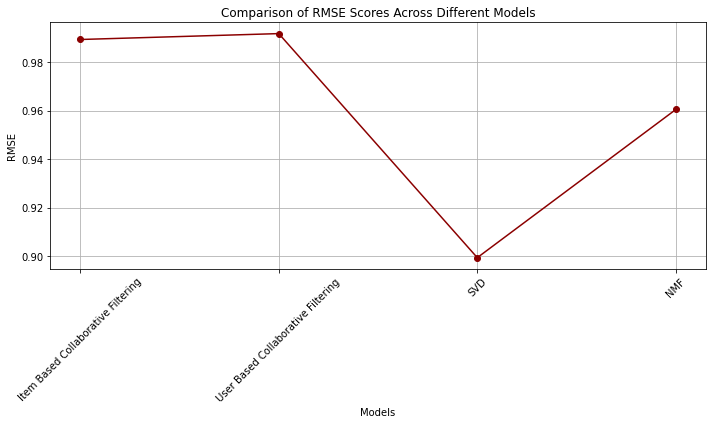

In [116]:
models = ["Item Based Collaborative Filtering", "User Based Collaborative Filtering", "SVD", "NMF"]
rmses = [rmse_item, rmse_user, rmse_SVD, rmse_nmf]

plt.figure(figsize=(10, 6))
plt.plot(models, rmses, marker='o', linestyle='-', color='darkred', label='RMSE')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Scores Across Different Models')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()